# Hyper-parameter setting

In [2]:
p_id = 106
hyper_param = {
    "contamination": 'auto',
    "n_neighbors": 20
}

## 1) Read data and downsample

In [3]:
%reload_ext autoreload
%autoreload
%matplotlib inline
from myHelper import timing
from myHelper import GraphSignalHelper
import numpy as np
from myHelper import db_helper
import networkx as nx

DB_dir ='./mitbih-database/'
p_id = '106'
r_detect = 'two_aver'
    
data_df = db_helper.read_heartbeat_database(DB_dir, p_id, nRowsRead=None)
annotations_df = db_helper.read_annotation_database(DB_dir, p_id)

# downsampling the signal
downstep = 2
(downsp_data_df, downsp_annotations_df) = GraphSignalHelper.downsample(data_df,
                                                               annotations_df,
                                                               downstep)

## 2) Fixed size split

In [4]:
# # split the the signal into heartbeat using the R-peak detection
# heart_beats, hbs_annotations = GraphSignalHelper.heartbeat_spliting(downsp_data_df, 
#                                                     downsp_annotations_df,
#                                                     R_detector=r_detect,
#                                                     fs = (360 / downstep))
# split the the signal into (fixed) heartbeat using the R-peak detection
heart_beats, hbs_annotations = GraphSignalHelper.fixed_heartbeat_spliting(downsp_data_df, 
                                                                          downsp_annotations_df,
                                                                          R_detector=r_detect,
                                                                          fs = (360 / downstep))
np.save('temp/heart_beats_'+str(p_id), heart_beats)
heart_beats = np.load('temp/heart_beats_'+str(p_id)+'.npy')

## 2.1) Calculate event distance matrix

In [14]:
from myHelper import dis_mat
vec_dis_mat = dis_mat.cal_vec_dist_mat(heart_beats)
np.save('temp/vec_dis_mat_'+str(p_id), vec_dis_mat)
vec_dis_mat = np.load('temp/vec_dis_mat_'+str(p_id)+'.npy')

cal_vec_dist_mat took 191.48659706115723   mil sec


## 3) Generate graph

In [5]:
# labeling heartbeats by looking at their annotations into 
# (-1) or (1) for Anomalous or Normal
hb_labels = GraphSignalHelper.anomaly_labels(hbs_annotations)


graph_stream, graph_stream_labels = GraphSignalHelper.generate_graph_stream(heart_beats, 
                                                                            hb_labels)
np.save('temp/hb_labels_'+str(p_id), hb_labels)
hb_labels = np.load('temp/hb_labels_'+str(p_id)+'.npy')
np.save('temp/graph_stream_'+str(p_id), graph_stream)
graph_stream = np.load('temp/graph_stream_'+str(p_id)+'.npy')

print("Number of graphs = ", len(graph_stream))
print(nx.info(graph_stream[0]))
# 2086

2086

## 3.1)Create Signature vectors of graphs

In [12]:
from myHelper import netSimile
signatures = []

for index, graph in graph_stream.items():
    signature = netSimile.aggregate_features(graph)
    signatures.append(signature)
    netSimile.show_progress('Aggregating features: ',index + 1, len(graph_stream))

np.save('temp/signatures_'+str(p_id), signatures)
signatures = np.load('temp/signatures_'+str(p_id)+'.npy')

Aggregating features:  100.000000% Complete

## 3.2) Calculate signature distance matrix

In [15]:
from myHelper import dis_mat
sig_dis_mat = dis_mat.cal_sig_dist_mat(signatures)
np.save('temp/sig_dis_mat_'+str(p_id), sig_dis_mat)
sig_dis_mat = np.load('temp/sig_dis_mat_'+str(p_id)+'.npy')

cal_sig_dist_mat took 81.78067207336426   mil sec


## 4) Confusion matrix Event-Based Anomaly Detection

vec_out_det_dis_mat took 81.78091049194336   mil sec

Number of errors =  580

accuracy = 0.722
precision  0.7463
recall  0.9505
F1 score on Test 0.8362
(ROC AUC) Score =  0.44422347760525366


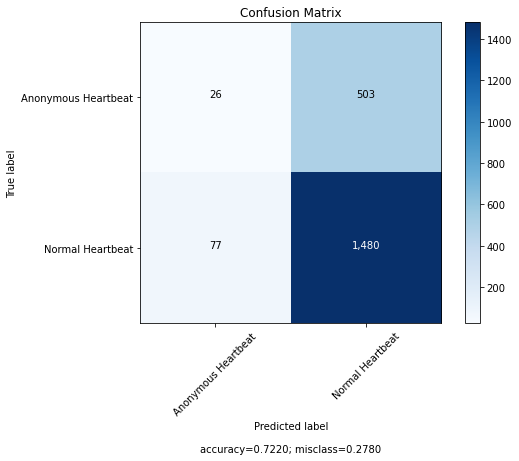

In [19]:
from myHelper import anomaly_detection

vector_y_pred, vector_y_scores = anomaly_detection.vec_out_det_dis_mat(vec_dis_mat,
                                                                       n_neighbors=hyper_param[ "n_neighbors"],
                                                                       contamination=hyper_param[ "contamination"],
                                                                       n_process= -1)
anomaly_detection.anomaly_plotter(hb_labels, vector_y_pred, vector_y_scores)

## 4) Confusion matrix Graph-Based (Graph Signature) Anomaly Detection

vec_out_det_dis_mat took 96.74072265625   mil sec

Number of errors =  509

accuracy = 0.756
precision  0.7579
recall  0.9891
F1 score on Test 0.8582
(ROC AUC) Score =  0.630868824614249


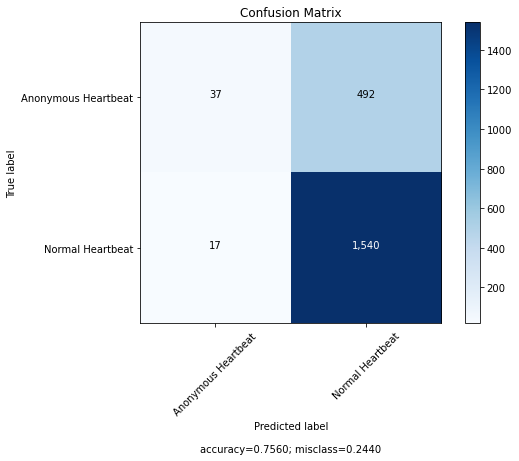

In [20]:
from myHelper import anomaly_detection

sig_y_pred, sig_y_scores = anomaly_detection.vec_out_det_dis_mat(sig_dis_mat,
                                                                 n_neighbors=hyper_param[ "n_neighbors"],
                                                                 contamination=hyper_param[ "contamination"],
                                                                 n_process= -1)
anomaly_detection.anomaly_plotter(hb_labels, sig_y_pred, sig_y_scores)

## (Precision-Recall Curve) 

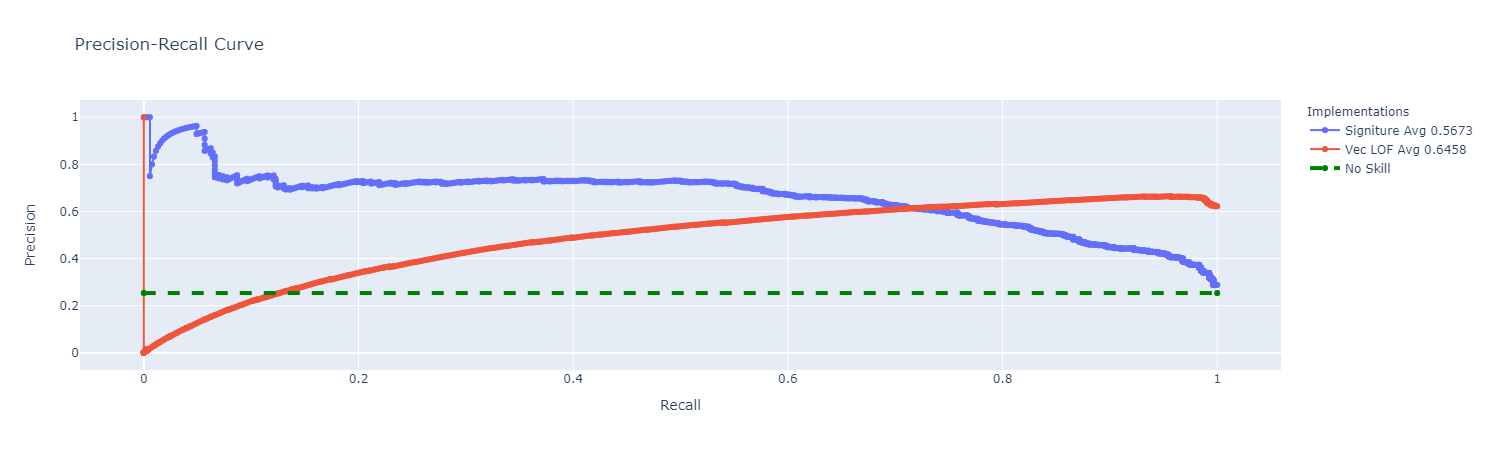

In [30]:
from myHelper import analytics
from myHelper import anomaly_detection

y_zero_one = anomaly_detection.zero_one_label_converter(hb_labels)
analytics.sig_pre_recall(vec_dis_mat,
                         sig_dis_mat,
                         hb_labels,
                         y_zero_one,
                         vec_n_neighbors=hyper_param[ "n_neighbors"],
                         vec_c =hyper_param[ "contamination"],
                         sig_n_neighbors=hyper_param[ "n_neighbors"],
                         sig_c=hyper_param[ "contamination"],
                         n_process = -1)

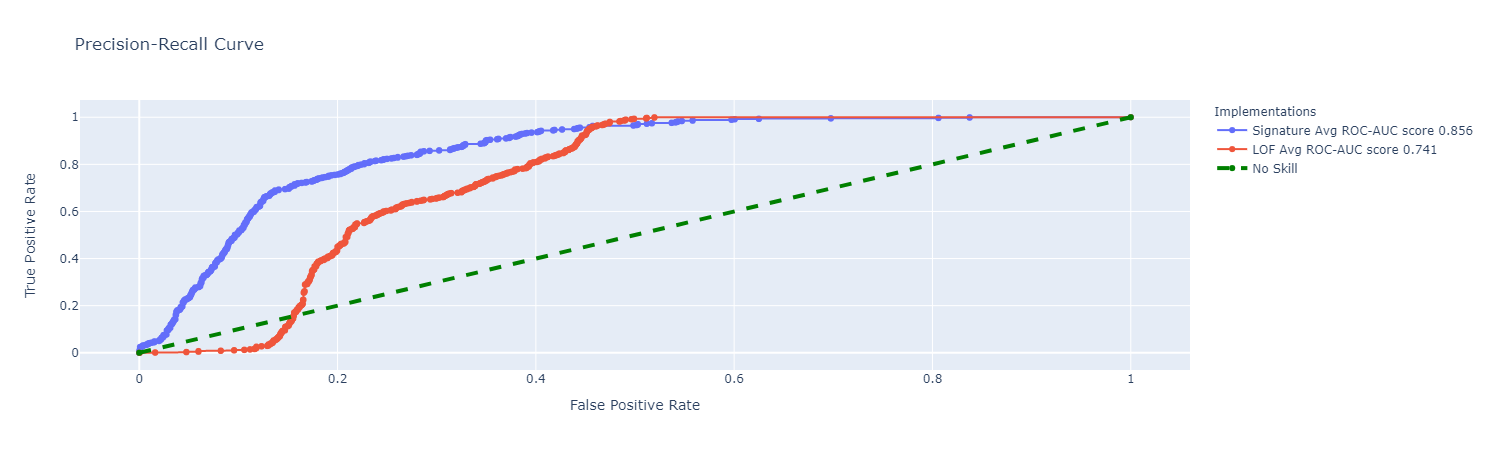

In [63]:
from myHelper import analytics
from myHelper import anomaly_detection

y_zero_one = anomaly_detection.zero_one_label_converter(hb_labels)

analytics.sig_roc_curve(vec_dis_mat,
                        sig_dis_mat,
                        hb_labels,
                        y_zero_one,
                        vec_n_neighbors=hyper_param[ "n_neighbors"],
                        vec_c =hyper_param[ "contamination"],
                        sig_n_neighbors=hyper_param[ "n_neighbors"],
                        sig_c=hyper_param[ "contamination"],
                        n_process = -1)